In [1]:
#import ROOT as r
import coffea
import coffea.hist as hist
from coffea.nanoevents.methods import vector
import uproot
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

from pyjet import cluster
import awkward as ak

In [2]:
def getLZDF(f,nEvents=-1):
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events

In [ ]:
events_1 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/HNL_electronType_mHNL10p0_pl100/HeavyNeutralLepton_Tree_0.root")
events_2 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/HNL_electronType_mHNL7p0_pl100/HeavyNeutralLepton_Tree_0.root")
t_m10_ct1000 = getLZDF("/uscms/home/kkwok/lpclonglived/HNL/HNL_electronType_mHNL7p0_pl100/HeavyNeutralLepton_Tree_0.root")

In [ ]:
acc10 = ak.sum(ak.firsts(events_1.gLLP_csc))/len(events_1)
acc7 = ak.sum(ak.firsts(events_2.gLLP_csc))/len(events_2)

In [ ]:
acc10

In [ ]:
hep.set_style(hep.style.CMS)

In [ ]:
h = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("ctau","catu[mm]",100,0,100))
h2 = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("r","r[mm]",100,0,500))

fig, axs = plt.subplots(1,2,figsize=(16,6))

axs = axs.flatten()

h.fill(sample="10GeV,ct=100mm",ctau=np.array(ak.firsts(events_1.gLLP_ctau)))
h.fill(sample="7GeV,ct=100mm",ctau=np.array(ak.firsts(events_2.gLLP_ctau)))
h2.fill(sample="10GeV,ct=100mm",r=np.array(ak.firsts(events_1.gLLP_decay_vertex_r)))
h2.fill(sample="7GeV,ct=100mm",r=np.array(ak.firsts(events_2.gLLP_decay_vertex_r)))
hist.plot1d(h,ax = axs[0],density=True)
hist.plot1d(h2,ax = axs[1],density=True)
axs[0].set_ylim(1e-6,1)
axs[0].set_yscale("log")
axs[1].set_ylim(1e-6,1)
axs[1].set_yscale("log")

In [ ]:
h.integrate("sample","10GeV,ct=100mm")

In [ ]:
import uproot3

In [ ]:
fout = uproot3.recreate("ctau.root")
fout["m_10_ct100_ctau"] = hist.export1d(h.integrate("sample","10GeV,ct=100mm"))
fout["m_7_ct100_ctau"] = hist.export1d(h.integrate("sample","7GeV,ct=100mm"))

In [3]:
events_1 = getLZDF("root://cmsxrootd.fnal.gov//store/user/lpclonglived/HNL/skim/HNL_muonType_mHNL1p0_pl100/HeavyNeutralLepton_Tree_0.root")

In [4]:
events=events_1
llp=ak.zip({
            'pt':events.gLLP_pt,
            #'EMfrac':events.gLLP_EMFracE,
            'e':events.gLLP_e,
            'eta':events.gLLP_eta,
            'z':events.gLLP_decay_vertex_z ,
            'r':events.gLLP_decay_vertex_r,
            'ctau':events.gLLP_ctau,
        })

lep=ak.zip({
            'pt':events.lepPt ,
            'eta':events.lepEta,
            'phi':events.lepPhi,
            'energy':events.lepE,
            'pdgid':events.lepPdgId,
            'passId':events.lepPassId,
        },with_name='PtEtaPhiELorentzVector',
        behavior=vector.behavior
        )
ele   = lep[abs(lep.pdgid)==11]
muons = lep[abs(lep.pdgid)==13]




cluster_dir= ak.zip(
{       
        'pt':ak.ones_like(events.cscRechitCluster3Eta),
        "eta":events.cscRechitCluster3Eta,
        "phi":events.cscRechitCluster3Phi,
        'mass':ak.zeros_like(events.cscRechitCluster3Eta)
    },with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior
)

good_ele = ele[(ele.pt>35) & (abs(ele.eta)<2.4) & (ele.passId)]

dphi_cluster_ele = ak.fill_none(cluster_dir.delta_phi(ak.firsts(good_ele)),-999)
dr_cluster_ele = ak.fill_none(cluster_dir.delta_r(ak.firsts(good_ele)),-999)

good_mu  = muons[(muons.pt>25)&(abs(muons.eta)<2.4) & (muons.passId)]

dphi_cluster_mu = ak.fill_none(cluster_dir.delta_phi(ak.firsts(good_mu)),-999)
dr_cluster_mu = ak.fill_none(cluster_dir.delta_r(ak.firsts(good_mu)),-999)
cluster= ak.zip(
    {
        "time":events.cscRechitCluster3TimeTotal,
        "size":events.cscRechitCluster3Size,
        "timeSpread":events.cscRechitCluster3TimeSpread,
        "eta":events.cscRechitCluster3Eta,
        "phi":events.cscRechitCluster3Phi,
        "x":events.cscRechitCluster3X,
        "y":events.cscRechitCluster3Y,
        "z":events.cscRechitCluster3Z,
        'llp_x':events.cscRechitCluster3_match_gLLP_decay_x,
        'llp_y':events.cscRechitCluster3_match_gLLP_decay_y,
        'llp_z':events.cscRechitCluster3_match_gLLP_decay_z,
        "NChamber":events.cscRechitCluster3NChamber,
        "MaxChamber":events.cscRechitCluster3MaxChamber,
        "MaxStation":events.cscRechitCluster3MaxStation,
        "NStation10":events.cscRechitCluster3NStation10,
        "AvgStation10":events.cscRechitCluster3AvgStation10,
        "ME11_12":(events.cscRechitCluster3Me11Ratio+events.cscRechitCluster3Me12Ratio)*events.cscRechitCluster3Size,
        "llp_match":events.cscRechitCluster3_match_gLLP,
        "RE12":events.cscRechitCluster3_match_RE12_0p4,
        "MB1seg":events.cscRechitCluster3_match_MB1Seg_0p4,
        "RB1":events.cscRechitCluster3_match_RB1_0p4,
        "dphi_cluster_MET":events.cscRechitCluster3MetXYCorr_dPhi,
        "dphi_cluster_ele":dphi_cluster_ele,
        "dphi_cluster_mu" :dphi_cluster_mu,
        "dr_cluster_ele": dr_cluster_ele,
        "dr_cluster_mu" : dr_cluster_mu,
        }
)

muVeto=ak.zip({
    'e':events.cscRechitCluster3MuonVetoE,
    "time":events.cscRechitCluster3Time,
    'pt':events.cscRechitCluster3MuonVetoPt,
    'phi':events.cscRechitCluster3MuonVetoPhi,
    'eta':events.cscRechitCluster3MuonVetoEta,
    'LooseIso':events.cscRechitCluster3MuonVetoLooseIso,
    'LooseId':events.cscRechitCluster3MuonVetoLooseId,
    'TightId':events.cscRechitCluster3MuonVetoTightId,
})


jetVeto=ak.zip({
    'e':events.cscRechitCluster3JetVetoE,
    'pt':events.cscRechitCluster3JetVetoPt,
    'phi':events.cscRechitCluster3JetVetoPhi,
    'eta':events.cscRechitCluster3JetVetoEta,
})


ClusterID =((cluster.NStation10>1) & (abs(cluster.eta)<1.9))|\
((cluster.NStation10==1) &(abs(cluster.AvgStation10)==4) & (abs(cluster.eta)<1.8))|\
((cluster.NStation10==1) &(abs(cluster.AvgStation10)==3) & (abs(cluster.eta)<1.6))|\
((cluster.NStation10==1) &(abs(cluster.AvgStation10)==2) & (abs(cluster.eta)<1.6))

muonVeto_mask = ~((muVeto.pt>20) & abs(muVeto.eta<2.4))

jetVeto_mask  = ~((jetVeto.pt>10)& abs(jetVeto.eta<2.4))
RE12_veto    = (cluster.RE12==0)
MB1seg_veto  = (cluster.MB1seg==0)
RB1_veto     = (cluster.RB1==0)
ME11_12_veto = (cluster.ME11_12==0)

OOT_timeCut   = (cluster.time < -12.5) #OOT for data
IntimeCut     = (cluster.time < 12.5) & (cluster.time>-5) ## In-time otherwise        
timeSpreadCut = (cluster.timeSpread<20)
dphi_MET      = (cluster.dphi_cluster_MET<0.75)
dphi_ele      = (cluster.dphi_cluster_ele>2.5)
dphi_mu       = (cluster.dphi_cluster_mu>2.5)
dr_ele        = (cluster.dr_cluster_ele>0.4)
dr_mu         = (cluster.dr_cluster_mu>0.4)


cls_OOT = cluster[
        ((jetVeto_mask) &(muonVeto_mask))
        & (dr_mu)
        & (ME11_12_veto)
        & ((MB1seg_veto) & (RB1_veto))
        & (OOT_timeCut)
        & (timeSpreadCut)
        & (ClusterID)
    ]
cls_ABCD = cluster[
    ((jetVeto_mask) &(muonVeto_mask))
    & (dr_mu)
    & (ME11_12_veto)
    & ((MB1seg_veto) & (RB1_veto))
    & (IntimeCut)
    & (timeSpreadCut)
    & (ClusterID)
]

cls_StaVeto = cluster[
     (ME11_12_veto)& ((MB1seg_veto) & (RB1_veto))
]
cls_JetMuVeto = cluster[
    ((jetVeto_mask) &(muonVeto_mask))& (dr_mu)
]
cls_JetMuStaVeto = cluster[
    ((jetVeto_mask) &(muonVeto_mask))
    & (dr_mu)
    & (ME11_12_veto)
    & ((MB1seg_veto) & (RB1_veto))
]
cls_JetMuVeto_without_dr = cluster[
    ((jetVeto_mask) &(muonVeto_mask))
]

dr_mu_0p4         = (cluster.dr_cluster_mu>0.4)

cls_JetMuVeto_with_dr_0p4 = cluster[
((jetVeto_mask) &(muonVeto_mask)&(cluster.dr_cluster_mu>0.4))
]

dr_mu_0p8         = (cluster.dr_cluster_mu>0.8)

cls_JetMuVeto_with_dr_0p8 = cluster[
    ((jetVeto_mask) &(muonVeto_mask)&(dr_mu_0p8))
]
dr_mu_0p0         = (cluster.dr_cluster_mu>0.0)

cls_JetMuVeto_with_dr_0p0 = cluster[
    ((jetVeto_mask) &(muonVeto_mask)&(dr_mu_0p0))
]

In [5]:

trigger_mu = events.SingleMuonTrigger==True
good_mu_sel = ak.num(good_mu,axis=1)==1
METfilters = events.Flag2_all==True
MET= events.metXYCorr>30

preselections = trigger_mu & good_mu_sel & METfilters & MET
cls_JetMuVeto_with_dr_0p4_sel= ak.num(cls_JetMuVeto_with_dr_0p4,axis=1)==1
cls_JetMuVeto_with_dr_0p0_sel= ak.num(cls_JetMuVeto_with_dr_0p0,axis=1)>0
dr_cut_solo = ak.num((cluster.dr_cluster_mu>0.4),axis=1)==0

<AxesSubplot:xlabel='drmu', ylabel='Count'>

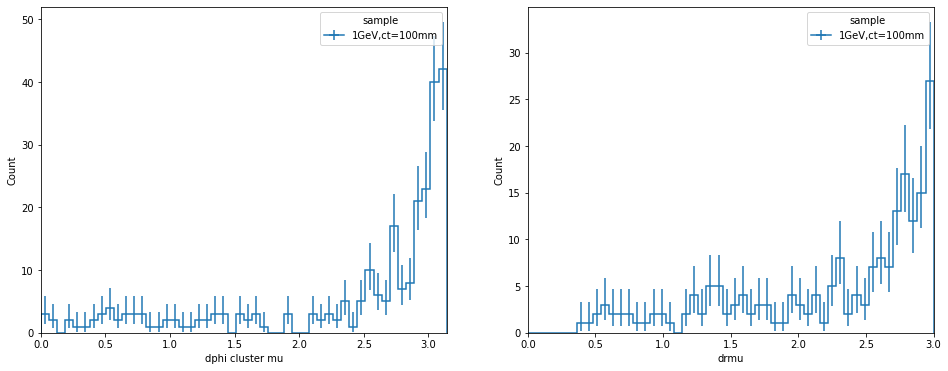

In [10]:
cluster_selection = cluster.dr_cluster_mu>0.4
selection = cluster[cluster.dr_cluster_mu>0.4]
dr_cut_solo = ak.num(selection,axis=1)==1

selections =dr_cut_solo
dr_arr = cluster[selections &cluster_selection].dr_cluster_mu
dphi_arr = cluster[selections &cluster_selection].dphi_cluster_mu

h = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dphi","dphi cluster mu",50,0,np.pi))

h2 = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dr_mu","drmu",50,0,3))

fig, axs = plt.subplots(1,2,figsize=(16,6))

axs = axs.flatten()


h.fill(sample="1GeV,ct=100mm",dphi=ak.flatten(dphi_arr))
h2.fill(sample="1GeV,ct=100mm",dr_mu=ak.flatten(dr_arr))

hist.plot1d(h,ax = axs[0],density=False)
hist.plot1d(h2,ax = axs[1],density=False)

#axs[0].set_ylim(1e-6,1)
#axs[0].set_yscale("log")


In [ ]:
h = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dphi","dphi cluster mu",50,0,np.pi))

h2 = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dr_mu","drmu",50,0,3))

fig, axs = plt.subplots(1,2,figsize=(16,6))

axs = axs.flatten()
print(ak.firsts(cluster.dphi_cluster_mu[preselections]))

h.fill(sample="1GeV,ct=100mm",dphi=np.array(ak.flatten(cluster[preselections&cls_JetMuVeto_with_dr_0p4_sel].dphi_cluster_mu)))
h2.fill(sample="1GeV,ct=100mm",dr_mu=np.array(ak.flatten(cluster[preselections&cls_JetMuVeto_with_dr_0p4_sel].dr_cluster_mu)))

hist.plot1d(h,ax = axs[0],density=False)
hist.plot1d(h2,ax = axs[1],density=False)

#axs[0].set_ylim(1e-6,1)
#axs[0].set_yscale("log")


In [ ]:
selection = (cluster.dr_cluster_mu>0.8) &(jetVeto_mask) &(muonVeto_mask) & trigger_mu & good_mu_sel & METfilters & MET
print(selection)
h = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dphi","dphi cluster mu",50,0,np.pi))

h2 = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dr_mu","drmu",50,0,3))

fig, axs = plt.subplots(1,2,figsize=(16,6))

axs = axs.flatten()
print(ak.firsts(cluster.dphi_cluster_mu[selection]))

h.fill(sample="1GeV,ct=100mm",dphi=np.array(ak.flatten(cluster.dphi_cluster_mu[selection])))
h2.fill(sample="1GeV,ct=100mm",dr_mu=np.array(ak.flatten(cluster.dr_cluster_mu[selection])))

hist.plot1d(h,ax = axs[0],density=False)
hist.plot1d(h2,ax = axs[1],density=False)

#axs[0].set_ylim(1e-6,1)
#axs[0].set_yscale("log")


[True, True, True, True, True, True, True, ... True, True, True, True, True, True]


<AxesSubplot:xlabel='drmu', ylabel='Count'>

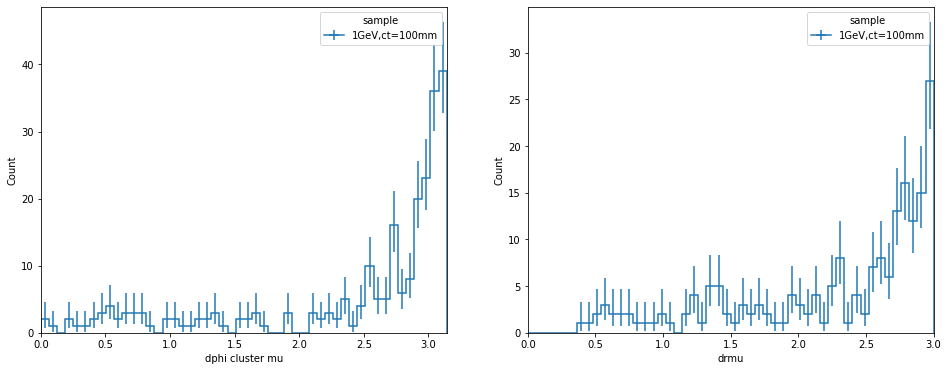

In [46]:
dr_cut_solo = cluster.dr_cluster_mu>0.4
n_cluster = cluster.dr_cluster_mu>-1.0


test_cut = ak.num(cluster.dr_cluster_mu>0.0,axis=1)==1 & ak.any(cluster.dr_cluster_mu>0.4,axis=1)
selection = test_cut

print(selection)
h = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dphi","dphi cluster mu",50,0,np.pi))

h2 = hist.Hist("Count",
             hist.Cat("sample","sample"),
             hist.Bin("dr_mu","drmu",50,0,3))

fig, axs = plt.subplots(1,2,figsize=(16,6))

axs = axs.flatten()


h.fill(sample="1GeV,ct=100mm",dphi=np.array(ak.flatten(cluster[selection].dphi_cluster_mu)))
h2.fill(sample="1GeV,ct=100mm",dr_mu=np.array(ak.flatten(cluster[selection].dr_cluster_mu)))

hist.plot1d(h,ax = axs[0],density=False)
hist.plot1d(h2,ax = axs[1],density=False)

#axs[0].set_ylim(1e-6,1)
#axs[0].set_yscale("log")


In [36]:
a = ak.Array([[200,50],[50],[10],[200]])
a>150
b = a[a>150]

In [32]:
ak.num(a>150,axis=1)>0

<Array [True, True, True, True] type='4 * bool'>

In [37]:
ak.num(b,axis=1)

<Array [1, 0, 0, 1] type='4 * int64'>

In [5]:
from HNLprocessor.HNLproc_4 import MyProcessor
lep=ak.zip({
    'pt':events.lepPt ,
    'eta':events.lepEta,
    'phi':events.lepPhi,
    'energy':events.lepE,
    'pdgid':events.lepPdgId,
    'passId':events.lepPassId,
},with_name='PtEtaPhiELorentzVector',
behavior=vector.behavior
)

ele   = lep[abs(lep.pdgid)==11]
muons = lep[abs(lep.pdgid)==13]
good_ele = ele[(ele.pt>35) & (abs(ele.eta)<2.4) & (ele.passId)]
good_mu  = muons[(muons.pt>25)&(abs(muons.eta)<2.4) & (muons.passId)]

def buildMask(allMasks,cutnames):
    allcuts = allMasks[cutnames[0]]
    for i,cutname in enumerate(cutnames):
        allcuts = (allcuts) & allMasks[cutname]
    return allcuts
p = MyProcessor()
cluster = p.buildCSCcluster(events,good_mu)
clusterMasks = p.selectCSCcluster(cluster,events)
preselections = ['trigger_ele','MET',"METfilters",'good_electron']
selectionMasks={}
selectionMasks['Acceptance']   =ak.firsts(events.gLLP_csc)==1
selectionMasks['Acceptance_dt']=ak.firsts(events.gLLP_dt)==1
selectionMasks['METfilters']   =events.Flag2_all==True
selectionMasks['trigger_ele']  =events.SingleEleTrigger==True
selectionMasks['trigger_mu']   =events.SingleMuonTrigger==True
selectionMasks['good_electron']=ak.num(good_ele,axis=1)==1
selectionMasks['good_mu']      =ak.num(good_mu,axis=1)==1
selectionMasks['MET']          =events.metEENoise>=30
selectionMasks['n_cls']        =ak.num(cluster,axis=1)>=1
selectionMasks['cls_ABCD']  = (   ((clusterMasks.jetVeto_mask) &(clusterMasks.muonVeto_mask))
    & (clusterMasks.ME11_12_veto)
    &((clusterMasks.MB1seg_veto) & (clusterMasks.RB1_veto))
    & (clusterMasks.IntimeCut)
    & (clusterMasks.timeSpreadCut)
    & (clusterMasks.ClusterID))
regions = {
            "ABCD"         :preselections+["cls_ABCD"],
            # "ABCD_OOT"     :preselections+["cls_OOT"],
}

cut = buildMask(selectionMasks,regions['ABCD'])



SyntaxError: invalid syntax (<ipython-input-5-4602522c96a7>, line 1)